In [16]:
#Installation
!pip uninstall -y numpy torch torchvision torchaudio -q
!pip install numpy==1.26.4 --no-cache-dir --force-reinstall -q
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 torchtext==0.16.2 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers datasets scikit-learn -q

print(
    "Setup complete.\n\n"
    "Please RESTART the runtime manually to apply changes:\n"
    "1. Go to the top menu: Runtime → Restart Runtime\n"
    "2. After the restart, execute the notebook from Cell 2 onwards.\n\n"
    "All necessary installations have been completed and applied in Cell 1, thus post session-restart, start the execution from Cell 2."
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 226.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.16.2+cpu requires torch==2.1.2, which is not installed.
accelerate 1.5.2 requires torch>=2.0.0, which is not installed.
sentence-transformers 3.4.1 requires torch>=1.11.0, which is not installed.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
peft 0.14.0 requires torch>=1.13.0, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.1.2%2Bcu118-cp311-cp311-linux_x86_64.whl (2325.9 MB)


Setup complete.

Please RESTART the runtime manually to apply changes:
1. Go to the top menu: Runtime → Restart Runtime
2. After the restart, execute the notebook from Cell 2 onwards.

All necessary installations have been completed and applied in Cell 1, thus post session-restart, start the execution from Cell 2.


In [17]:
# Import
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.functional import softmax, log_softmax
from torchtext.vocab import GloVe
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Loading IMDb dataset
dataset = load_dataset("imdb")

# Shuffling train set for randomness
train_data = dataset["train"].shuffle(seed=42)
test_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


In [4]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.289200,0.219231,0.912600,0.912868


TrainOutput(global_step=1563, training_loss=0.28923205511736244, metrics={'train_runtime': 703.0461, 'train_samples_per_second': 35.56, 'train_steps_per_second': 2.223, 'total_flos': 1655842483200000.0, 'train_loss': 0.28923205511736244, 'epoch': 1.0})

In [6]:
teacher_model.save_pretrained("my_teacher_model")
tokenizer.save_pretrained("my_teacher_model")

('my_teacher_model/tokenizer_config.json',
 'my_teacher_model/special_tokens_map.json',
 'my_teacher_model/vocab.txt',
 'my_teacher_model/added_tokens.json',
 'my_teacher_model/tokenizer.json')

In [7]:
# Generating Teacher Logits
def get_logits(model, dataloader):
    model.eval()
    logits_list = []
    labels_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits_list.append(outputs.logits.cpu())
            labels_list.append(labels.cpu())

    return torch.cat(logits_list), torch.cat(labels_list)

teacher_loader = DataLoader(train_data, batch_size=32)
teacher_logits, true_labels = get_logits(teacher_model, teacher_loader)

In [8]:
torch.save(teacher_logits, "teacher_logits.pt")

In [9]:
glove = GloVe(name="6B", dim=300)

In [10]:
embedding_dim = 300
vocab_size = tokenizer.vocab_size
embedding_matrix = torch.zeros((vocab_size, embedding_dim))

for i in range(vocab_size):
    token = tokenizer.convert_ids_to_tokens(i)
    if token in glove.stoi:
        embedding_matrix[i] = glove[token]
    else:
        embedding_matrix[i] = torch.randn(embedding_dim) * 0.05

In [11]:
import torch.nn.functional as F

class StudentCNN(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, output_dim=2):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.conv3 = nn.Conv1d(300, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(300, 128, kernel_size=4, padding=2)
        self.conv5 = nn.Conv1d(300, 128, kernel_size=5, padding=2)

        self.dropout = nn.Dropout(0.3)
        self.norm = nn.LayerNorm(128 * 3)
        self.fc = nn.Linear(128 * 3, output_dim)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = x.permute(0, 2, 1)

        x3 = F.relu(self.conv3(x))
        x4 = F.relu(self.conv4(x))
        x5 = F.relu(self.conv5(x))

        x3 = torch.max(x3, dim=2).values
        x4 = torch.max(x4, dim=2).values
        x5 = torch.max(x5, dim=2).values

        x_cat = torch.cat((x3, x4, x5), dim=1)
        x_cat = self.norm(x_cat)
        x_cat = self.dropout(x_cat)
        return self.fc(x_cat)

In [12]:
student_model = StudentCNN(vocab_size, embedding_matrix).to(device)

criterion_ce = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction="batchmean")
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
temperature = 2.0

student_model.train()
for epoch in range(1):
    total_loss = 0
    for i, batch in enumerate(teacher_loader):
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        soft_targets = softmax(teacher_logits[i*32:(i+1)*32].to(device) / temperature, dim=1)
        student_logits = student_model(input_ids)
        soft_logits = log_softmax(student_logits / temperature, dim=1)

        loss_ce = criterion_ce(student_logits, labels)
        loss_kd = criterion_kd(soft_logits, soft_targets) * (temperature ** 2)
        loss = 0.3 * loss_ce + 0.7 * loss_kd

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

Epoch 1 | Loss: 310.5682


In [13]:
# Final Evaluation of Teacher and Student
def evaluate(model, dataset):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=32)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            if hasattr(model, "config"):
                attention_mask = batch["attention_mask"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
            else:
                logits = model(input_ids)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return acc, f1

# Evaluate
teacher_acc, teacher_f1 = evaluate(teacher_model, test_data)
student_acc, student_f1 = evaluate(student_model, test_data)

print(f"Teacher Accuracy: {teacher_acc:.4f}, F1 Score: {teacher_f1:.4f}")
print(f"Student Accuracy: {student_acc:.4f}, F1 Score: {student_f1:.4f}")

Teacher Accuracy: 0.9126, F1 Score: 0.9129
Student Accuracy: 0.8666, F1 Score: 0.8576


In [14]:
# Save trained student model
torch.save(student_model.state_dict(), "student_cnn.pt")

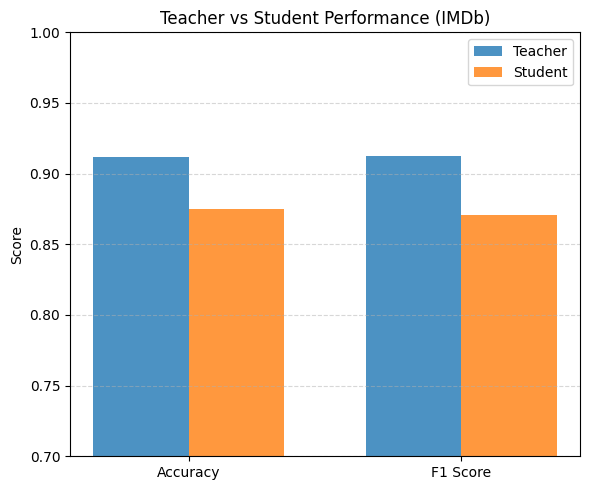

In [15]:
import matplotlib.pyplot as plt

# Final scores
teacher_acc = 0.9119
teacher_f1 = 0.9125
student_acc = 0.8751
student_f1 = 0.8706

# Bar chart
labels = ['Accuracy', 'F1 Score']
teacher_scores = [teacher_acc, teacher_f1]
student_scores = [student_acc, student_f1]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(6, 5))
plt.bar([i - width/2 for i in x], teacher_scores, width=width, label='Teacher', alpha=0.8)
plt.bar([i + width/2 for i in x], student_scores, width=width, label='Student', alpha=0.8)

plt.xticks(x, labels)
plt.ylim(0.7, 1.0)
plt.ylabel('Score')
plt.title('Teacher vs Student Performance (IMDb)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("teacher_vs_student_comparison.png", dpi=300)
plt.show()